In [ ]:
!pip install remotezip tqdm opencv-python einops
# Install TensorFlow 2.10
#!pip install tensorflow==2.10.0
! pip install opencv-python-headless==4.8.0.76
! pip install tf-models-official

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 849.5 kB/s eta 0:00:00
  Created wheel for remotezip: filename=remotezip-0.12.2-py3-none-any.whl size=7890 sha256=85d911d8845bf95e5d2f0e43455cf27fe9410efd1f127fad072a81960038cbfe
  Stored in directory: /root/.cache/pip/wheels/f2/71/f9/c650cc34039d772da8b040ed447b6b5f5de9abc38d88073fa1
Successfully built remotezip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

(https://github.com/ZFTurbo/classification_models_3D)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as tfkeras
from keras import layers

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)

  return frame

def frames_from_video_file(video_path, n_frames, output_size = (448,448), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
n_frames = 8
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.Path("/content/drive/MyDrive/data/data_video/train"), n_frames, training=True),
                                          output_signature = output_signature)


#Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.Path("/content/drive/MyDrive/data/data_video/val"), n_frames),
                                         output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.Path("/content/drive/MyDrive/data/data_video/test"), n_frames),
                                          output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [ ]:
! pip install classification-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
! pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00


In [ ]:
from classification_models_3D.tfkeras import Classifiers
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import measure
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras import backend as K
from keras.layers import Dropout, Dense, Activation, GlobalAveragePooling3D
from keras.models import Model

#use_weights = 'imagenet'
shape_size = (8, 224, 224, 3)
backbone = 'inceptionresnetv2'
num_classes = 5

learning_rate = 0.0001
patience = 5
epochs = 50
steps_per_epoch = 158
validation_steps = 20
dropout_val = 0.1

modelPoint, preprocess_input = Classifiers.get(backbone)
model = modelPoint(
    input_shape=shape_size,
    include_top=False
    #weights=use_weights,
)
x = model.layers[-1].output
x = GlobalAveragePooling3D()(x)
x = Dropout(dropout_val)(x)
x = Dense(num_classes, name='prediction')(x)
x = Activation('softmax')(x)
model = Model(inputs=model.inputs, outputs=x)

print(model.summary())
optim = Adam(learning_rate=learning_rate)

loss_to_use = tfkeras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optim, loss=loss_to_use, metrics='acc')


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=3, min_lr=1e-9, min_delta=1e-8, verbose=1, mode='min'),
    CSVLogger('history_{}_lr_{}.csv'.format(backbone, learning_rate), append=True),
    EarlyStopping(monitor='val_loss', patience=patience, verbose=0, mode='min'),
]


history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    verbose=1,
    max_queue_size=10,
    initial_epoch=0,
    callbacks=callbacks
)

best_loss = max(history.history['val_loss'])
print('Training finished. Loss: {}'.format(best_loss))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8, 224, 224, 3)]     0         []                            
                                                                                                  
 conv3d_203 (Conv3D)         (None, 4, 112, 112, 32)      2592      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 4, 112, 112, 32)      96        ['conv3d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_204 (Activation  (None, 4, 112, 112, 32)      0         ['batch_normalization_20

158/158 [==============================] - 83s 522ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 2.3292 - val_acc: 0.1410 - lr: 1.0000e-04
Training finished. Loss: 2.3291592597961426


In [ ]:
model.evaluate(test_ds, return_dict=True)

20/20 [==============================] - 193s 10s/step - loss: 2.3427 - acc: 0.1429


{'loss': 2.342698574066162, 'acc': 0.1428571492433548}

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted


def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of video content classification for ' + ds_type)
  ax.set_xlabel('Predicted video content')
  ax.set_ylabel('Actual video content')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
fg = FrameGenerator(pathlib.Path("/content/drive/MyDrive/data/data_video/train"), n_frames, training = True)
labels = list(fg.class_ids_for_name.keys())

158/158 [==============================] - 654s 4s/step


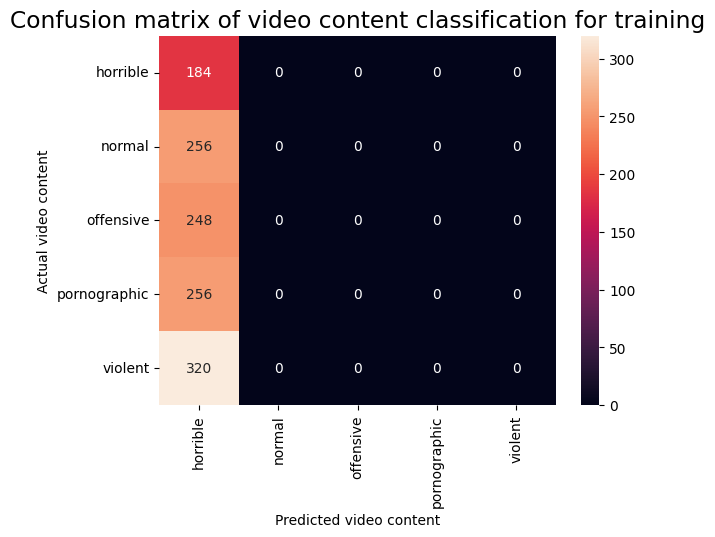

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

20/20 [==============================] - 78s 4s/step


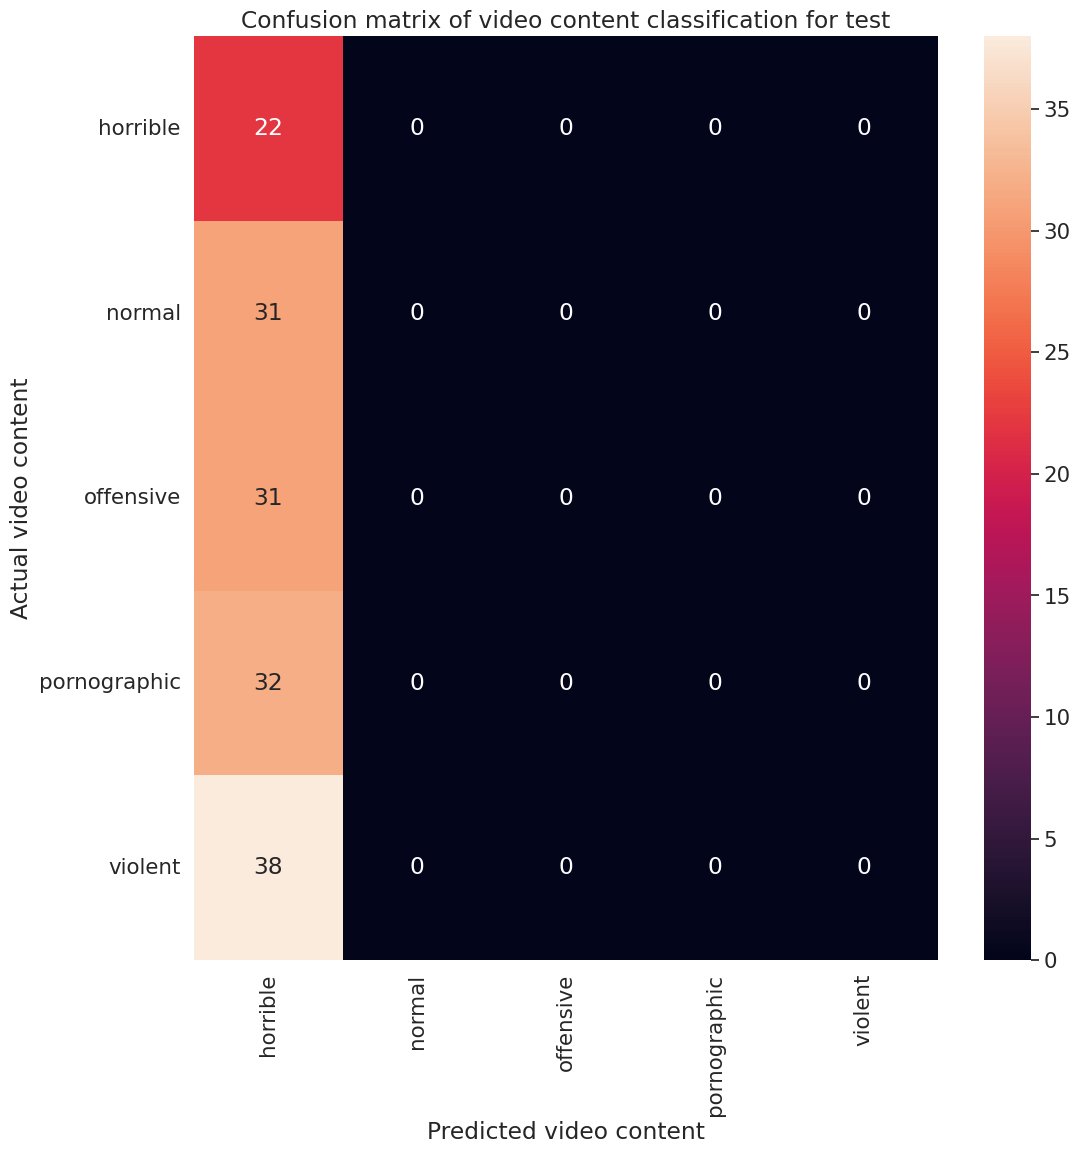

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset
# Calculate Macro Precision
macro_precision = sum(precision.values()) / len(precision)

# Calculate Macro Recall
macro_recall = sum(recall.values()) / len(recall)

# Calculate Macro F1-score
macro_f1_score = (2 * macro_precision * macro_recall) / (macro_precision + macro_recall)

print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1-score:", macro_f1_score)

NameError: name 'calculate_classification_metrics' is not defined

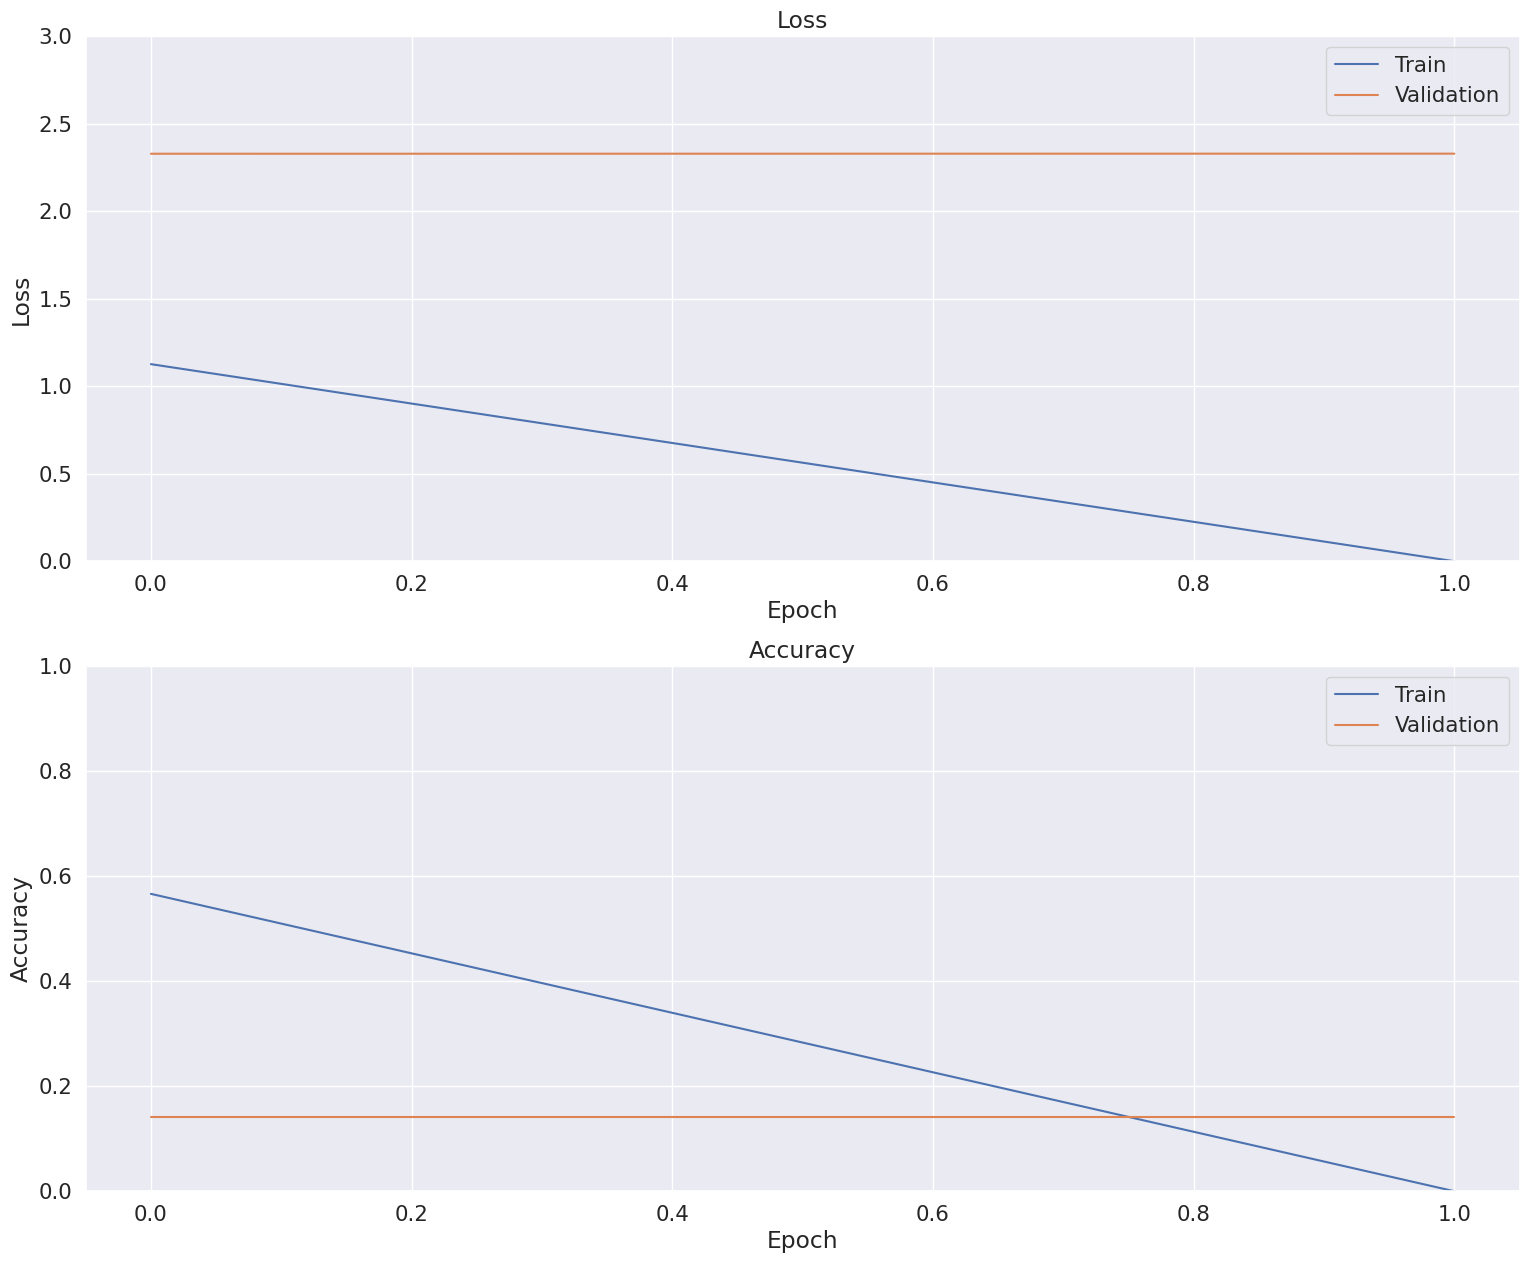

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 15)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['acc'],  label = 'train')
  ax2.plot(history.history['val_acc'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)